<a href="https://colab.research.google.com/github/henrycgbaker/nlp_research_note/blob/main/research_note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install datasets fasttext evaluate

import os
import kagglehub
import pandas as pd
import numpy as np
from datasets import Dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import spacy
import spacy.cli
from sklearn.feature_extraction.text import CountVectorizer
import fasttext.util as fasttext_util
import fasttext
from sklearn.metrics import f1_score
from collections import Counter
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import tqdm
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate
from sklearn.metrics import f1_score, accuracy_score
import warnings
import sys
from sklearn.metrics import f1_score
from tqdm import tqdm

warnings.filterwarnings("ignore")

/Users/henrybaker/miniconda3/envs/nlp_1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hertie server
'''
import os
# Set the environment variables
os.environ['HOME_CONFIG'] = './/workspace/workspace'
os.environ['KAGGLE_CONFIG'] = './workspace/workspace/.kaggle'
os.environ['SPACY_CACHE'] = '/workspace/workspace/cache'

# Optionally, check if the environment variables were set correctly
print(os.getenv('HOME_CONFIG'))
print(os.getenv('KAGGLE_CONFIG'))
print(os.getenv('SPACY_CACHE'))
'''

"\nimport os\n# Set the environment variables\nos.environ['HOME_CONFIG'] = './/workspace/workspace'\nos.environ['KAGGLE_CONFIG'] = './workspace/workspace/.kaggle'\nos.environ['SPACY_CACHE'] = '/workspace/workspace/cache'\n\n# Optionally, check if the environment variables were set correctly\nprint(os.getenv('HOME_CONFIG'))\nprint(os.getenv('KAGGLE_CONFIG'))\nprint(os.getenv('SPACY_CACHE'))\n"

In [3]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# download pretrained embeddings -----------------------------------------------
# for local
#fasttext.util.download_model('en', if_exists='ignore')
ft_path = "./cc.en.300.bin"

# for Colab
# !pip install datasets fasttext evaluate
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir('/content/drive/Othercomputers/My MacBook Pro/Documents/repositories/nlp/nlp_research_note')
#ft_path = "./cc.en.300.bin"

ft = fasttext.load_model(ft_path)

# download spacy model for tokenization ----------------------------------------
cache_path = './cache/'
os.makedirs(cache_path, exist_ok=True)
os.environ['SPACY_DATA'] = cache_path
spacy.cli.download("en_core_web_sm")

# load helper functions & scripts ----------------------------------------------
'''
sys.path.append('./aux_scripts')
from  misinfo_tokenizer import (get_trained_tokenizer,
                                batch_tokenize,
                                #vocab_mapping,
                                custom_analyzer
                                )
from data_loader_helpers import (#Collator,
                                 embedding_mapping_fasttext
                                 )
'''

python(3888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.0 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


"\nsys.path.append('./aux_scripts')\nfrom  misinfo_tokenizer import (get_trained_tokenizer,\n                                batch_tokenize,\n                                #vocab_mapping,\n                                custom_analyzer\n                                )\nfrom data_loader_helpers import (#Collator,\n                                 embedding_mapping_fasttext\n                                 )\n"

---
# Import & process Hugging Face `misinfo` dataset

In [5]:
# Download latest version
misinfo_path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")
print("Path to dataset files:", misinfo_path)

ds = load_dataset(misinfo_path)
print(ds)

Path to dataset files: /Users/henrybaker/.cache/kagglehub/datasets/saurabhshahane/fake-news-classification/versions/77
DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 72134
    })
})


python(3895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [6]:
# DATA PARTITIONING =====================================================================
ds_cloned = ds.copy()


df = ds_cloned['train'].to_pandas()

columns_to_remove = ['Unnamed: 0', 'title']
df = df.drop(columns=columns_to_remove, errors='ignore')

print(df["text"].isnull().sum())  
df = df.dropna(subset=["text"])

df_misinfo_train, df_misinfo_test = train_test_split(df, test_size=0.2, random_state=42)

df_misinfo_train = df_misinfo_train.sample(n=5000, random_state=42) # REMOVE THIS
df_misinfo_test = df_misinfo_test.sample(n=5000, random_state=42) # REMOVE THIS

print(f"Train shape {df_misinfo_train.shape} \n")
print('(0 = fake and 1 = real).\n')
print("Training positive vs negative examples: \n", df_misinfo_train.value_counts("label")/df_misinfo_train.shape[0])
print("\nTesting positive vs negative examples: \n",df_misinfo_test.value_counts("label")/df_misinfo_test.shape[0])

df_misinfo_train.head()

39
Train shape (5000, 2) 

(0 = fake and 1 = real).

Training positive vs negative examples: 
 label
1    0.51
0    0.49
Name: count, dtype: float64

Testing positive vs negative examples: 
 label
1    0.5172
0    0.4828
Name: count, dtype: float64


,text,label
26093,Share on Twitter The Wildfire is an opinion pl...,1
8593,Military British Defense Secretary Michael Fal...,1
4551,Missing from much of the news media coverage o...,0
12755,BERLIN (Reuters) - It is incredibly unlikely ...,0
56423,FRANKFURT (Reuters) - Germany’s largest bank h...,0


In [7]:
# DEFINE TOKENIZATION FLOW =====================================================================

nlp = spacy.load("en_core_web_sm", 
                 disable=["tok2vec", "tagger", "parser", "ner", "lemmatizer", "attribute_ruler"])

def custom_tokenizer(text):
    tokenized_text = nlp(text)
    return [tok.text for tok in tokenized_text]

def custom_analyzer(text, trained_tokenizer):
    """
    Uses the custom_tokenizer, then replaces out-of-vocabulary tokens with <unk>.
    """
    tokens = custom_tokenizer(text)
    vocab = trained_tokenizer.vocabulary_
    return [token if token in vocab else "<unk>" for token in tokens]

def get_trained_tokenizer(text_series, tokenizer_file=None, min_df=3):
    """
    1) Checks if a previously fitted tokenizer exists in tokenizer_file.
    2) If not, create a new CountVectorizer, fit it on 'text_series'.
    3) Save the fitted tokenizer if tokenizer_file is provided.
    4) Return the tokenizer.
    """
    # If a tokenizer file path is given and exists, load it
    if tokenizer_file and os.path.exists(tokenizer_file):
        print(f"Tokenizer file '{tokenizer_file}' found. Loading it...")
        with open(tokenizer_file, 'rb') as f:
            tokenizer = pickle.load(f)
    else:
        # Otherwise, create a new one and fit
        print("No pre-fitted tokenizer found or no file specified. Creating a new one...")
        tokenizer = CountVectorizer(
            analyzer="word",
            tokenizer=custom_tokenizer,  # We define custom_tokenizer for splitting
            lowercase=False,
            min_df=min_df
        )
        tokenizer.fit(text_series)
        
        # Save the tokenizer if a path was provided
        if tokenizer_file:
            print(f"Saving fitted tokenizer to '{tokenizer_file}'...")
            with open(tokenizer_file, 'wb') as f:
                pickle.dump(tokenizer, f)

    return tokenizer

def batch_tokenize(text_series, batch_size, analyzer_func):
    """
    Tokenizes a Pandas Series of text in batches to avoid memory issues.
    """
    tokenized_result = []
    total = len(text_series)
    num_batches = (total // batch_size) + (1 if total % batch_size != 0 else 0)
    
    for batch_idx in range(0, total, batch_size):
        
        # Print progress every 200 batches or at the last batch
        if (batch_idx // batch_size + 1) % 200 == 0 or (batch_idx + batch_size >= total):
            print(f'Tokenizing batch {batch_idx // batch_size + 1} of {num_batches}...')
        
        batch_texts = text_series[batch_idx : batch_idx + batch_size]
        for text in batch_texts:
            tokenized_result.append(analyzer_func(text))
    
    return tokenized_result

# TOKENIZATION ==========================================================================

TOKENIZER_DIR = './cache/misinfo_tokenizer.pkl'
TRAIN_TOKENISED_DIR = './cache/misinfo_train_tokenised.pkl'
TEST_TOKENISED_DIR = './cache/misinfo_test_tokenised.pkl'

if os.path.exists(TRAIN_TOKENISED_DIR) and os.path.exists(TEST_TOKENISED_DIR):
    print("Tokenized text pkl files found: loading data...")
    # Load pre-saved tokenized data
    with open(TRAIN_TOKENISED_DIR, 'rb') as f:
        misinfo_train_tokenised = pickle.load(f)
    with open(TEST_TOKENISED_DIR, 'rb') as f:
        misinfo_test_tokenised = pickle.load(f)

else:
    print("Pickle files not found. Running tokenization...")

    # 1) Train tokenizer
    misinfo_tokenizer = get_trained_tokenizer(
        df_misinfo_train["text"],
        tokenizer_file=TOKENIZER_DIR,
        min_df=3
    )

    # Build the default analyzer from our tokenizer
    misinfo_tokenizer_analyzer = misinfo_tokenizer.build_analyzer()

    # 2) Tokenize train data in batches using the built analyzer (trained on train set)
    print("Tokenizing Train Data in Batches...")
    misinfo_train_tokenised = batch_tokenize(
        df_misinfo_train["text"],
        32,
        misinfo_tokenizer_analyzer
    )
    
    # 3) Tokenize test data in batches using custom_analyzer (which replaces OOV tokens with <unk>)
    print("Tokenizing Test Data in Batches...")
    misinfo_test_tokenised = batch_tokenize(
        df_misinfo_test["text"],
        32,
        lambda text: custom_analyzer(text, trained_tokenizer=misinfo_tokenizer)
    )

    # Optionally, save the tokenized data
    with open(TRAIN_TOKENISED_DIR, 'wb') as f:
        pickle.dump(misinfo_train_tokenised, f)
    with open(TEST_TOKENISED_DIR, 'wb') as f:
        pickle.dump(misinfo_test_tokenised, f)

print("Train inputs tokenised:", len(misinfo_train_tokenised))
print("Test inputs tokenised:", len(misinfo_test_tokenised))

Tokenized text pkl files found: loading data...
Train inputs tokenised: 5000
Test inputs tokenised: 5000


In [8]:
# STEP 1: INPUT PIPELINE ================================================================

# vocabulary indexing -------------------------------------------------------------------

def vocab_mapping(tokenized_text):
    token_counts = Counter()
    for text in tokenized_text:
        token_counts.update(text)
    special_tokens = ["<pad>", "<unk>"]
    vocab_tokens = special_tokens + [token for token, freq in token_counts.most_common()]
    vocab = {token: idx for idx, token in enumerate(vocab_tokens)}
    return vocab

vocab_idx = vocab_mapping(tokenized_text=misinfo_train_tokenised)

print(f"Vocab size: {len(vocab_idx)}")
print(f"Vocab example: {list(vocab_idx.items())[:10]}")

Vocab size: 83115
Vocab example: [('<pad>', 0), ('<unk>', 1), (',', 2), ('the', 3), ('.', 4), ('to', 5), ('of', 6), ('and', 7), ('a', 8), ('in', 9)]


In [9]:

# create data loaders -------------------------------------------------------------------

def collate_fn(data, include_lengths=True):
    text_list, label_list, lengths = [], [], []
    for _text, _label in data:
        # Integer encoding with truncation
        processed_text = torch.tensor([vocab_idx[token] for token in _text][:max_seq_length],
                                      dtype=torch.int64)
        text_list.append(processed_text)
        label_list.append(_label)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    # Padding
    padded_text_list = nn.utils.rnn.pad_sequence(text_list,
                                                 batch_first=True,
                                                 padding_value=0)
    if include_lengths:
        return padded_text_list, label_list, lengths
    else:
        return padded_text_list, label_list

max_seq_length = 300 # too long for full RNNs
batch_size = 32

# standard dls with collate_fn
train_dl = DataLoader(dataset=list(zip(misinfo_train_tokenised,
                                         df_misinfo_train["label"])),
                        batch_size=32, shuffle=True, 
                        collate_fn=lambda x: collate_fn(x, include_lengths=True))

test_dl = DataLoader(dataset=list(zip(misinfo_test_tokenised,
                                         df_misinfo_test["label"])),
                        batch_size=32, shuffle=False, 
                        collate_fn=lambda x: collate_fn(x, include_lengths=True))

# dls w/o collate_fn for CNNs:
train_dl_cnn = DataLoader(dataset=list(zip(misinfo_train_tokenised,
                                         df_misinfo_train["label"])),
                        batch_size=32, shuffle=True,
                        collate_fn=lambda x: collate_fn(x, include_lengths=False))

test_dl_cnn = DataLoader(dataset=list(zip(misinfo_test_tokenised,
                                         df_misinfo_test["label"])),
                         batch_size=32, shuffle=True,
                        collate_fn=lambda x: collate_fn(x, include_lengths=False))

In [10]:
# EMBEDDING MAPPING =====================================================================

# map pretrained fasttext embeddings to vocabulary indices ------------------------------

EMBEDDINGS_FILE_PATH = "./cache/mapped_pretrained_embeddings.pkl"

def embedding_mapping_fasttext(vocabulary, pre_trained_embeddings):
    vocab_size = len(vocabulary)
    embedding_dim = pre_trained_embeddings.get_dimension()
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for idx, word in enumerate(vocabulary):
        embedding_matrix[idx] = pre_trained_embeddings.get_word_vector(word)
    return embedding_matrix

if os.path.exists(EMBEDDINGS_FILE_PATH):
    with open(EMBEDDINGS_FILE_PATH, 'rb') as f:
        embedding_tensor = pickle.load(f)
    print(f"Emebddings pre-exists: loaded embeddings from {EMBEDDINGS_FILE_PATH}. Shape: {embedding_tensor.shape}")
else:
    print("Embeddings do not pre-exist: mapping pretrained fasttext embeddings to vocabulary indices")

    mapped_pretrained_embeddings = embedding_mapping_fasttext(vocabulary=vocab_idx,
                                                              pre_trained_embeddings=ft)
    embedding_tensor = torch.FloatTensor(mapped_pretrained_embeddings)

    # Save embeddings
    with open(EMBEDDINGS_FILE_PATH, 'wb') as f:
        pickle.dump(embedding_tensor, f)
    print(f"Saved embeddings to {EMBEDDINGS_FILE_PATH}. Shape: {embedding_tensor.shape}")


Emebddings pre-exists: loaded embeddings from ./cache/mapped_pretrained_embeddings.pkl. Shape: torch.Size([83115, 300])


In [11]:
def train(model, num_epochs, train_dl, test_dl, use_lengths=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCEWithLogitsLoss()

    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model.to(device)

    metrics = {
        "loss_train": [],
        "loss_test": [],
        "accuracy_train": [],
        "accuracy_test": [],
        "f1_train": [],
        "f1_test": []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0, 0
        all_train_preds, all_train_labels = [], []

        print(f"Epoch {epoch + 1}/{num_epochs} Training...")
        for batch in tqdm(train_dl, desc="Training", leave=False):
            if use_lengths:
                x_batch, y_batch, lengths = batch
                x_batch, y_batch, lengths = x_batch.to(device), y_batch.to(device), lengths.to(device)
                pred = model(x_batch, lengths)[:, 0]  # Include lengths for RNNs/LSTMs
            else:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)[:, 0]

            # Compute loss
            loss = loss_fn(pred, y_batch.float())

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Metrics
            train_loss += loss.item() * y_batch.size(0)
            preds = (pred >= 0.5).float()
            train_correct += (preds == y_batch).float().sum().item()
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(y_batch.cpu().numpy())

        metrics["loss_train"].append(train_loss / len(train_dl.dataset))
        metrics["accuracy_train"].append(train_correct / len(train_dl.dataset))
        metrics["f1_train"].append(f1_score(all_train_labels, all_train_preds))

        # Evaluation phase
        model.eval()
        test_loss, test_correct = 0, 0
        all_test_preds, all_test_labels = [], []
        print(f"Epoch {epoch + 1}/{num_epochs} Evaluating...")
        with torch.no_grad():
            for batch in tqdm(test_dl, desc="Evaluating", leave=False):
                if use_lengths:
                    x_batch, y_batch, lengths = batch
                    x_batch, y_batch, lengths = x_batch.to(device), y_batch.to(device), lengths.to(device)
                    pred = model(x_batch, lengths)[:, 0]
                else:
                    x_batch, y_batch = batch
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    pred = model(x_batch)[:, 0]

                # Compute loss
                loss = loss_fn(pred, y_batch.float())

                # Metrics
                test_loss += loss.item() * y_batch.size(0)
                preds = (pred >= 0.5).float()
                test_correct += (preds == y_batch).float().sum().item()
                all_test_preds.extend(preds.cpu().numpy())
                all_test_labels.extend(y_batch.cpu().numpy())

        metrics["loss_test"].append(test_loss / len(test_dl.dataset))
        metrics["accuracy_test"].append(test_correct / len(test_dl.dataset))
        metrics["f1_test"].append(f1_score(all_test_labels, all_test_preds))

        # Print summary
        print(f"Epoch {epoch + 1}/{num_epochs} Summary:")
        print(f"    Train - Loss: {metrics['loss_train'][-1]:.4f}, Accuracy: {metrics['accuracy_train'][-1]:.3f}, F1: {metrics['f1_train'][-1]:.3f}")
        print(f"    Test  - Loss: {metrics['loss_test'][-1]:.4f}, Accuracy: {metrics['accuracy_test'][-1]:.3f}, F1: {metrics['f1_test'][-1]:.3f}")

    return metrics

In [12]:
# MODEL BUILDING ================================================================

# CNN-based text classification model

class TextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layers
        convolution_layer = nn.Conv1d(in_channels=embedding_tensor.size(1),
                                      out_channels=128,
                                      kernel_size=3,
                                      padding="same")
        activation_layer = nn.ReLU()
        pooling_layer = nn.AdaptiveAvgPool1d(1)
        h_layers = [convolution_layer, activation_layer, pooling_layer]
        self.hidden_layers = nn.ModuleList(h_layers)
        # classification layer
        self.classification_layer = nn.Linear(in_features=128, out_features=1)

    # define forward pass
    def forward(self, x):
        x = self.embedding_layer(x).permute(0, 2, 1)

        for layer in self.hidden_layers:
            x = layer(x)

        x = x.squeeze(2)

        x = self.classification_layer(x)
        return x

model_cnn = TextClassificationModel(embedding_tensor=embedding_tensor)

In [13]:
# Train the model
num_epochs = 10

if os.path.exists("./models/cnn_model.pth"):
    model_cnn = torch.load("./models/cnn_model.pth")
    print("Model loaded from disk.")
else:
    print("Training the model...")
    num_epochs = 10
    hist_cnn = train(model_cnn, num_epochs, train_dl_cnn, test_dl_cnn, use_lengths=False)
    print("Training the model...")
    with open("./models/train_hist/cnn_hist.pkl", "wb") as f:
        pickle.dump(hist_cnn, f)
    torch.save(model_cnn, "./models/cnn_model.pth")

Model loaded from disk.


In [14]:

# EXTENSION 1: RNN =====================================================================

class RNNTextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layer
        self.rnn_layer = nn.RNN(input_size=embedding_tensor.size(1),
                                hidden_size=32,
                                num_layers=1, # increase to stack RNNs
                                batch_first=True)
        # classification layer
        self.classification_layer = nn.Linear(in_features=32, out_features=1)

    # define forward pass
    def forward(self, x, lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              lengths.cpu().numpy(),
                                              enforce_sorted=False,
                                              batch_first=True)
        o_t, h_t = self.rnn_layer(x) # o_t includes the outputs,
                                     # h_t the hidden state at the last time step
        x = h_t[-1, :, :] # extract from last layer (in case of num_layers > 1)
        x = self.classification_layer(x)
        return x

model_rnn = RNNTextClassificationModel(embedding_tensor=embedding_tensor)

if os.path.exists("./models/rnn_model.pth"):
    model_cnn = torch.load("./models/rnn_model.pth")
    print("Model loaded from disk.")
else:
    print("Training the model...")
    hist_rnn = train(model_rnn, num_epochs, train_dl, test_dl, use_lengths=True) 
    with open("./models/train_hist/rnn_hist.pkl", "wb") as f:
        pickle.dump(hist_rnn, f)

    torch.save(model_rnn, "./models/rnn_model.pth")

Model loaded from disk.


In [15]:

# EXTENSION 2: LSTM =====================================================================

class LSTMTextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layer
        self.lstm_layer = nn.LSTM(input_size=embedding_tensor.size(1),
                                  hidden_size=32,
                                  num_layers=1,
                                  batch_first=True)
        # classification layer
        self.classification_layer = nn.Linear(in_features=32, out_features=1)

    # define forward pass
    def forward(self, x, lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              lengths.cpu().numpy(),
                                              enforce_sorted=False,
                                              batch_first=True)
        o_t, (h_t, c_t) = self.lstm_layer(x) # c_t the cell state at the last time step
        x = h_t[-1, :, :] # extract from last layer (in case of num_layers > 1)
        x = self.classification_layer(x)
        return x

model_lstm = LSTMTextClassificationModel(embedding_tensor=embedding_tensor)

if os.path.exists("./models/lstm_model.pth"):
    model_cnn = torch.load("./models/lstm_model.pth")
    print("Model loaded from disk.")
else:
    print("Training the model...")
    hist_lstm = train(model_lstm, num_epochs=10, train_dl=train_dl, test_dl=test_dl, use_lengths=True)
    with open("./models/train_hist/lstm_hist.pkl", "wb") as f:
        pickle.dump(hist_rnn, f)
    torch.save(model_lstm, "./models/lstm_model.pth")

Model loaded from disk.


In [16]:

# EXTENSION 2.5: STACKING LSTM LAYERS WITH DIFFERENT HIDDEN SIZES =========================

class StackedLSTMTextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layer
        self.lstm_layer_1 = nn.LSTM(input_size=embedding_tensor.size(1),
                                    hidden_size=64,
                                    num_layers=1,
                                    batch_first=True)
        self.lstm_layer_2 = nn.LSTM(input_size=64,
                                    hidden_size=32,
                                    num_layers=1,
                                    batch_first=True)
        # classification layer
        self.classification_layer = nn.Linear(in_features=32, out_features=1)

    # define forward pass
    def forward(self, x, lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              lengths.cpu().numpy(),
                                              enforce_sorted=False,
                                              batch_first=True)
        o_t_1, (h_t_1, c_t_1) = self.lstm_layer_1(x)
        o_t_2, (h_t_2, c_t_2) = self.lstm_layer_2(o_t_1)
        x = h_t_2[-1, :, :]
        x = self.classification_layer(x)
        return x

model_lstm_stacked = StackedLSTMTextClassificationModel(embedding_tensor=embedding_tensor)

if os.path.exists("./models/lstm_stacked_model.pth"):
    model_lstm_stacked = torch.load("./models/lstm_stacked_model.pth")
    print("Model loaded from disk.")
else:
    print("Training the model...")
    hist_lstm_stacked = train(model_lstm_stacked, num_epochs, train_dl, test_dl, use_lengths=True)
    with open("./models/train_hist/lstm_stacked_hist.pkl", "wb") as f:
        pickle.dump(hist_lstm_stacked, f)
    torch.save(model_lstm_stacked, "./models/lstm_stacked_model.pth")

Model loaded from disk.


In [17]:

# EXTENSION 4: BI-DIRECTIONAL LSTM ======================================================

class BidirectionalLSTMTextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layer
        self.bid_lstm_layer = nn.LSTM(input_size=embedding_tensor.size(1),
                                      hidden_size=32,
                                      num_layers=1,
                                      batch_first=True,
                                      bidirectional=True)
        # classification layer
        self.classification_layer = nn.Linear(in_features=32*2, out_features=1)

    # define forward pass
    def forward(self, x, lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              lengths.cpu().numpy(),
                                              enforce_sorted=False,
                                              batch_first=True)
        o_t, (h_t, c_t) = self.bid_lstm_layer(x)
        x = torch.cat((h_t[-2, :, :],
                       h_t[-1, :, :]), dim=1)
        x = self.classification_layer(x)
        return x

model_bi_lstm = BidirectionalLSTMTextClassificationModel(embedding_tensor=embedding_tensor)

if os.path.exists("./models/bi_lstm_model.pth"):
    model_bi_lstm = torch.load("./models/bi_lstm_model.pth")
    print("Model loaded from disk.")
else:
    print("Training the model...")
    hist_bi_lstm = train(model_bi_lstm, num_epochs, train_dl, test_dl, use_lengths=True)
    with open("./models/train_hist/bi_lstm_hist.pkl", "wb") as f:
        pickle.dump(hist_bi_lstm, f)
    torch.save(model_bi_lstm, "./models/bi_lstm_model.pth")

Model loaded from disk.


# Transformer & Transfer Learning

In [18]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel

# Load checkpoint and tokenizer
checkpoint = "google/bert_uncased_L-2_H-128_A-2"
bert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert_uncased = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Define the features of the dataset
features = Features({
    'text': Value(dtype='string'),
    'label': ClassLabel(num_classes=2, names=['factual', 'misinfo']),
})

df_misinfo_train = df_misinfo_train.reset_index(drop=True)
df_misinfo_test = df_misinfo_test.reset_index(drop=True)

# Convert train and test data to Hugging Face Dataset
dataset_train = Dataset.from_pandas(df_misinfo_train, features=features)
dataset_test = Dataset.from_pandas(df_misinfo_test, features=features)

# Display the first few rows of the training dataset
print(dataset_train[2]) 

# Check the unique values of the 'label' column to ensure the classes are correct
unique_labels = set(dataset_train['label'])
print("Unique label values in training data:", unique_labels)

# Check the mapping of integer labels to class names
print("Class name mapping:", dataset_train.features['label'].int2str)

# Create a Hugging Face DatasetDict
dataset_dict = DatasetDict({
    'train': dataset_train,
    'test': dataset_test
})

# Print the DatasetDict to check its contents
print(f'\n {dataset_dict}')

print(dataset_train[2]) 
print(dataset_dict['train'][2])

{'text': 'Missing from much of the news media coverage of FBI Director James Comey’s testimony last week that   top Hillary Clinton aide Huma Abedin regularly forwarded classified emails to her husband, Anthony Weiner, is that the revelation directly contradicts Abedin’s own claims from last November about how the emails famously made it to Weiner’s laptop computer. [During last Wednesday’s Senate Judiciary Committee hearing on FBI oversight, Comey stated Abedin appears to have engaged in a “regular practice of forwarding  ” to Weiner’s computer, possibly for him to print out.  The testimony, which came during an exchange with Sen. John Kennedy ( ) about classified emails found on Weiner’s computer, went thusly: KENNEDY: OK. Was there classified information on  —   on former Congressman Weiner’s computer? COMEY: Yes. KENNEDY: Who sent it to him? COMEY: His then spouse, Huma Abedin, appears to have had a regular practice of forwarding   to him, for him I think to print out for her so sh

In [20]:
# tokenising the texts ================================================================

if os.path.exists("./data/misinfo_bert_tokenized"):
    tokenized_datasets = DatasetDict.load_from_disk("./data/misinfo_bert_tokenized")
    
else:
    print("Tokenizing...")                                      
    
    def tokenize_function(dataset):
        return bert_tokenizer(dataset["text"], truncation=True, padding="max_length", max_length=512)
        # truncates at 512 for the chosen checkpoint

    tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
    tokenized_datasets

    tokenized_datasets['train'][0]['text']
    tokenized_datasets['train'][0]['label']
    tokenized_datasets['train'][0]['input_ids']
    tokenized_datasets['train'][0]['attention_mask']
    
    tokenized_datasets.save_to_disk("./data/misinfo_bert_tokenized")

# fine-tuning the model ================================================================
    
if os.path.exists("./models/transformer_results/bert_uncased_finetuned.safetensor"):
    bert_tokenizer = AutoTokenizer.from_pretrained("./models/transformer_results")
    bert_uncased = AutoModelForSequenceClassification.from_pretrained("./models/transformer_results")
    print("Model loaded from disk.")
else:
    
    print("Fine tuning...")

    training_args = TrainingArguments(output_dir="./models/transformer_results/bert_uncased_finetuned",
                                    eval_strategy="epoch",
                                    save_strategy="epoch",
                                    per_device_train_batch_size=32,
                                    per_device_eval_batch_size=32,
                                    num_train_epochs=30,
                                    load_best_model_at_end=True,
                                    metric_for_best_model='f1',
                                    disable_tqdm=False,
                                    use_cpu=False)

    def compute_metrics(eval_preds):
        metric = evaluate.load("glue", "mrpc")
        logits, labels = eval_preds
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    trainer = Trainer(
        bert_uncased,
        training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    # Save the model and tokenizer after training
    trainer.save_model("./models/transformer_results")  
    bert_tokenizer.save_pretrained("./models/transformer_results")  

Fine tuning...


  3%|▎         | 157/4710 [00:45<19:57,  3.80it/s]Using the latest cached version of the module from /Users/henrybaker/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--glue/05234ba7acc44554edcca0978db5fa3bc600eeee66229abe79ff9887eacaf3ed (last modified on Sun Dec 22 00:40:44 2024) since it couldn't be found locally at evaluate-metric--glue, or remotely on the Hugging Face Hub.

  3%|▎         | 157/4710 [01:02<19:57,  3.80it/s]

{'eval_loss': 0.3986719846725464, 'eval_accuracy': 0.8476, 'eval_f1': 0.8559001512859304, 'eval_runtime': 17.232, 'eval_samples_per_second': 290.157, 'eval_steps_per_second': 9.111, 'epoch': 1.0}


  7%|▋         | 314/4710 [02:13<20:08,  3.64it/s]

{'eval_loss': 0.20952405035495758, 'eval_accuracy': 0.9256, 'eval_f1': 0.929277566539924, 'eval_runtime': 25.7787, 'eval_samples_per_second': 193.959, 'eval_steps_per_second': 6.09, 'epoch': 2.0}


                                                    
 10%|█         | 471/4710 [03:13<19:27,  3.63it/s]

{'eval_loss': 0.1440412551164627, 'eval_accuracy': 0.9452, 'eval_f1': 0.9480667172100076, 'eval_runtime': 15.7192, 'eval_samples_per_second': 318.082, 'eval_steps_per_second': 9.988, 'epoch': 3.0}


 11%|█         | 500/4710 [03:21<19:46,  3.55it/s]  

{'loss': 0.3264, 'grad_norm': 1.0890783071517944, 'learning_rate': 4.469214437367304e-05, 'epoch': 3.18}


                                                  
 13%|█▎        | 628/4710 [04:16<19:04,  3.57it/s]

{'eval_loss': 0.11397890746593475, 'eval_accuracy': 0.9618, 'eval_f1': 0.9632762930205729, 'eval_runtime': 18.9952, 'eval_samples_per_second': 263.225, 'eval_steps_per_second': 8.265, 'epoch': 4.0}


                                                    
 17%|█▋        | 785/4710 [05:16<18:15,  3.58it/s]

{'eval_loss': 0.11012965440750122, 'eval_accuracy': 0.9626, 'eval_f1': 0.9636822684016314, 'eval_runtime': 16.006, 'eval_samples_per_second': 312.383, 'eval_steps_per_second': 9.809, 'epoch': 5.0}


                                                    
 20%|██        | 942/4710 [06:17<17:33,  3.58it/s]

{'eval_loss': 0.11685270816087723, 'eval_accuracy': 0.9652, 'eval_f1': 0.9659090909090909, 'eval_runtime': 16.1464, 'eval_samples_per_second': 309.666, 'eval_steps_per_second': 9.724, 'epoch': 6.0}


 21%|██        | 1000/4710 [06:34<19:08,  3.23it/s] 

{'loss': 0.065, 'grad_norm': 15.168498039245605, 'learning_rate': 3.9384288747346076e-05, 'epoch': 6.37}


                                                   
 23%|██▎       | 1099/4710 [07:18<16:43,  3.60it/s]

{'eval_loss': 0.1109643280506134, 'eval_accuracy': 0.9686, 'eval_f1': 0.9698829848455783, 'eval_runtime': 15.9643, 'eval_samples_per_second': 313.198, 'eval_steps_per_second': 9.834, 'epoch': 7.0}


                                                     
 27%|██▋       | 1256/4710 [08:19<16:00,  3.60it/s]

{'eval_loss': 0.1391686350107193, 'eval_accuracy': 0.9636, 'eval_f1': 0.964299725382503, 'eval_runtime': 16.1086, 'eval_samples_per_second': 310.394, 'eval_steps_per_second': 9.746, 'epoch': 8.0}


                                                     
 30%|███       | 1413/4710 [09:20<15:07,  3.63it/s]

{'eval_loss': 0.12772008776664734, 'eval_accuracy': 0.9696, 'eval_f1': 0.97041650447645, 'eval_runtime': 16.58, 'eval_samples_per_second': 301.569, 'eval_steps_per_second': 9.469, 'epoch': 9.0}


 32%|███▏      | 1500/4710 [09:46<15:22,  3.48it/s]  

{'loss': 0.0228, 'grad_norm': 1.2410106658935547, 'learning_rate': 3.407643312101911e-05, 'epoch': 9.55}


                                                   
 33%|███▎      | 1570/4710 [10:23<14:48,  3.53it/s]

{'eval_loss': 0.14833740890026093, 'eval_accuracy': 0.9652, 'eval_f1': 0.965748031496063, 'eval_runtime': 17.2221, 'eval_samples_per_second': 290.324, 'eval_steps_per_second': 9.116, 'epoch': 10.0}


                                                     
 37%|███▋      | 1727/4710 [11:24<13:57,  3.56it/s]

{'eval_loss': 0.14136789739131927, 'eval_accuracy': 0.9696, 'eval_f1': 0.9704739704739704, 'eval_runtime': 16.2225, 'eval_samples_per_second': 308.213, 'eval_steps_per_second': 9.678, 'epoch': 11.0}


                                                     
 40%|████      | 1884/4710 [12:26<13:20,  3.53it/s]

{'eval_loss': 0.18439048528671265, 'eval_accuracy': 0.961, 'eval_f1': 0.9614090639224223, 'eval_runtime': 16.7099, 'eval_samples_per_second': 299.223, 'eval_steps_per_second': 9.396, 'epoch': 12.0}


 42%|████▏     | 2000/4710 [12:59<12:53,  3.50it/s]  

{'loss': 0.0096, 'grad_norm': 0.01946254074573517, 'learning_rate': 2.8768577494692145e-05, 'epoch': 12.74}


                                                   
 43%|████▎     | 2041/4710 [13:27<12:21,  3.60it/s]

{'eval_loss': 0.1631179004907608, 'eval_accuracy': 0.9678, 'eval_f1': 0.9684003925417075, 'eval_runtime': 16.2629, 'eval_samples_per_second': 307.449, 'eval_steps_per_second': 9.654, 'epoch': 13.0}


                                                     
 47%|████▋     | 2198/4710 [14:30<13:29,  3.10it/s]

{'eval_loss': 0.15312129259109497, 'eval_accuracy': 0.9696, 'eval_f1': 0.9703588143525741, 'eval_runtime': 17.4972, 'eval_samples_per_second': 285.76, 'eval_steps_per_second': 8.973, 'epoch': 14.0}


 47%|████▋     | 2198/4710 [14:30<16:35,  2.52it/s]

{'train_runtime': 870.9334, 'train_samples_per_second': 172.229, 'train_steps_per_second': 5.408, 'train_loss': 0.09705758778152952, 'epoch': 14.0}


In [21]:
def batch_predict(model, tokenizer, texts, batch_size=16, device='mps', max_length=512):
    """
    Predict labels for a batch of texts using the specified model and tokenizer.

    Parameters:
        model: The pre-trained model (e.g., BERT).
        tokenizer: The tokenizer associated with the pre-trained model.
        texts: List of input texts to predict.
        batch_size: Number of samples per batch.
        device: Device to use ('mps', 'cuda', or 'cpu').
        max_length: Maximum sequence length for tokenization.

    Returns:
        List of predicted labels.
    """
    model.to(device)
    model.eval()

    predictions = []

    with torch.no_grad():  # No gradients needed for prediction
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

            # Tokenize the batch with truncation and padding
            tokenized_batch = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )

            # Move tokenized inputs to the same device as the model
            tokenized_batch = {key: value.to(device) for key, value in tokenized_batch.items()}

            # Get model outputs
            outputs = model(**tokenized_batch)

            # Apply softmax to logits and determine predicted labels
            preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_labels = torch.argmax(preds, dim=1)

            # Collect predictions
            predictions.extend(predicted_labels.cpu().numpy())  # Move predictions to CPU before storing

    return predictions

# USAGE
# set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Prepare dataset
disinfo_test_texts = df_misinfo_test["text"].to_list()
true_labels = df_misinfo_test["label"].to_list()

# predictions in batches
predicted_labels = batch_predict(bert_uncased, bert_tokenizer, disinfo_test_texts, batch_size=16, device=device)

# Evaluate the performance
f1 = f1_score(true_labels, predicted_labels)
acc = accuracy_score(true_labels, predicted_labels)
print(f"F1 Score: {f1}")
print(f"Accuracy: {acc}")

Using device: mps
F1 Score: 0.9704739704739704
Accuracy: 0.9696


could do a load here about why the non-transformers didn't work so well (maybe a tweet is not long enough, didn;t do any hyperparameter tuning, non-decreasing LR means it often overshot; but of interest is that Transformers worked, so will take that moving forward)

---
# Climate Tweets

In [22]:
# reading climate df
input_path_climate = "/Users/henrybaker/.cache/kagglehub/datasets/die9origephit/climate-change-tweets/versions/1/Climate change_2022-1-17_2022-7-19.csv"
df_climate = pd.read_csv(input_path_climate)
print(f"Loading dataset from '{input_path_climate}'...")
df_climate.head(1)

Loading dataset from '/Users/henrybaker/.cache/kagglehub/datasets/die9origephit/climate-change-tweets/versions/1/Climate change_2022-1-17_2022-7-19.csv'...


,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,Lauren Boebert,@laurenboebert,2022-01-17T23:32:38.000Z,Lauren Boebert\n@laurenboebert\n·\nJan 18,The only solution I’ve ever heard the Left pro...,NaN,"1,683","2,259",11.7K,[],https://twitter.com/laurenboebert/status/14832...


In [23]:
df_climate_inference = df_climate[['Embedded_text']].rename(columns={'Embedded_text': 'text'})
print(f"Shape of inference dataset: {df_climate_inference.shape}")
df_climate_inference.head(2)

Shape of inference dataset: (9050, 1)


,text
0,The only solution I’ve ever heard the Left pro...
1,Climate change doesn’t cause volcanic eruption...


In [24]:
# TRANSFORMER INFERENCE ================================================================

model_path = "./models/transformer_results"
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_uncased = AutoModelForSequenceClassification.from_pretrained(model_path)

# Tokenize climate tweets
CLIMATE_TOKENISED_BERT_DIR = './cache/climate_tokenised_bert.pkl'

if os.path.exists(CLIMATE_TOKENISED_BERT_DIR):
    print("Tokenized climate tweets pkl file found. Loading data...")
    with open(CLIMATE_TOKENISED_BERT_DIR, 'rb') as f:
        climate_tokenised_bert = pickle.load(f)
else:
    print("Pickle file not found. Tokenizing climate tweets...")
    climate_tokenised_bert = bert_tokenizer(
        list(df_climate_inference["text"]),  
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    with open(CLIMATE_TOKENISED_BERT_DIR, 'wb') as f:
        pickle.dump(climate_tokenised_bert, f)
    print("Tokenized climate tweets and saved to file.")

# Predict using fine-tuned BERT model
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

def predict_climate_tweets(model, tokenized_texts, batch_size=32, device='mps'):
    model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():
        for i in range(0, len(tokenized_texts['input_ids']), batch_size):
            batch_input_ids = tokenized_texts['input_ids'][i:i + batch_size].to(device)
            batch_attention_mask = tokenized_texts['attention_mask'][i:i + batch_size].to(device)

            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_labels = torch.argmax(preds, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())

    return predictions

predicted_labels = predict_climate_tweets(bert_uncased, climate_tokenised_bert, batch_size=32, device=device)

Pickle file not found. Tokenizing climate tweets...
Tokenized climate tweets and saved to file.
Using device: mps


In [30]:
predicted_labels[:5]

[np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]

In [31]:
df_climate_inference['predicted_label'] = predicted_labels

# Replace 0 with 'factual' and 1 with 'misinformation' in the 'predicted_label' column
df_climate_inference['predicted_label'] = df_climate_inference['predicted_label'].replace({0: 'factual', 1: 'misinformation'})

# Display the updated dataframe
print(df_climate_inference.head())

# Save predictions to CSV
output_path_climate = "/Users/henrybaker/Documents/repositories/nlp/nlp_research_note/data/climate_predictions_bert.csv"
df_climate_inference.to_csv(output_path_climate, index=False)
print(f"Predictions saved to {output_path_climate}.")

                                                text predicted_label
0  The only solution I’ve ever heard the Left pro...  misinformation
1  Climate change doesn’t cause volcanic eruption...  misinformation
2  Vaccinated tennis ball boy collapses in the te...  misinformation
3  North America has experienced an average winte...         factual
4  They're gonna do the same with Climate Change ...  misinformation
Predictions saved to /Users/henrybaker/Documents/repositories/nlp/nlp_research_note/data/climate_predictions_bert.csv.


Distribution of Factual vs Misinformation:
predicted_label
misinformation    8640
factual            410
Name: count, dtype: int64


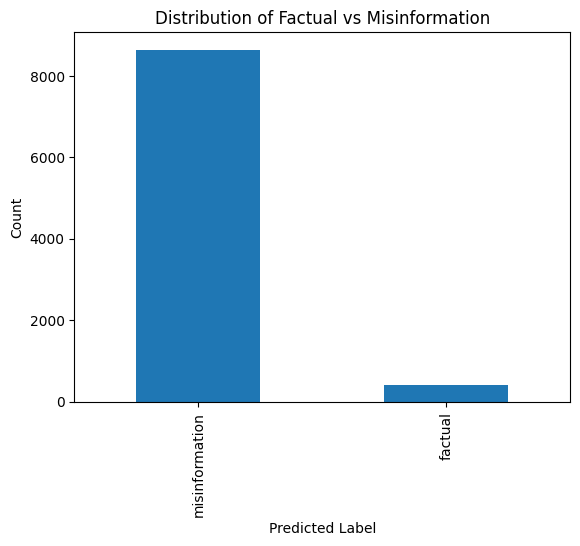

In [32]:
# Count occurrences of each label
label_counts = df_climate_inference['predicted_label'].value_counts()

print("Distribution of Factual vs Misinformation:")
print(label_counts)

# If you want to visualise this distribution:
import matplotlib.pyplot as plt

label_counts.plot(kind='bar')
plt.title('Distribution of Factual vs Misinformation')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.show()

learly overly categorising things as misinfo... I could retune to reduce more false positives, but given that it got 96+% on F1 score, the model is accurate to the dataset; the issue lies with either a) the internal validity of the dataset; b) the external valifity / OOD assumptions when applied to climate tweets.

a) looking at the constituent datasets, I can see how this happened...
b) climate tweets are different...inference write up: not great, overrepresentation of misinfo - prob because in the training data i used climate was disproportionately in the misinfo category -> out of distribution... generally it identifies factual well, but overly classifies as misinfo

was going to do an LDA, but unless the model is better performing, it makes more sense to do xAI to work out where it's performing badly

looking at the tweets labeled misinfo, it's clear the model doesn't understand the substantive poits / the science, it's just classifying on style

so next steps
1) clear up the tweets to remove the other text -> get it closer to the others text
2) xAI



In [27]:
# Extract 10 examples of factual (label == 0)
factual_examples = df_climate_inference[df_climate_inference['predicted_label'] == 'factual'].head(10)

# Extract 10 examples of misinformation (label == 1)
misinfo_examples = df_climate_inference[df_climate_inference['predicted_label'] == 'misinformation'].head(10)

print("10 Examples of Factual (predicted_label 0):")
print(factual_examples)

print("\n10 Examples of Misinformation (predicted_label 1):")
print(misinfo_examples)


10 Examples of Factual (predicted_label 0):
                                                  text predicted_label
3    North America has experienced an average winte...         factual
16   I saw my Amish friend Elton today. "Nice day."...         factual
87   The concept of living through a "discontinuity...         factual
89   Border security is national security, and it h...         factual
134  These investments are critical to building a s...         factual
139  Australian high temperature records.\nSpot the...         factual
167  In late 2019, I issued an Exec. Order on clima...         factual
168  Labor leader Anthony Albanese has gained an ed...         factual
169  .\n@POTUS\n leads with honesty and integrity, ...         factual
202  The Bank of Japan has made the first auction i...         factual

10 Examples of Misinformation (predicted_label 1):
                                                 text predicted_label
0   The only solution I’ve ever heard the Left pro...

# Non-Transfomer model

Next best was bidirectional RNN


In [28]:

# pipeline for RNNs etc 

def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]
    return {
        "input_ids": torch.stack(input_ids, dim=0),
        "attention_mask": torch.stack(attention_masks, dim=0),
    }

TOKENIZER_DIR = './cache/misinfo_tokenizer.pkl'
INFERENCE_TOKENISED_DIR = './cache/climate_tokenised.pkl'

if os.path.exists(INFERENCE_TOKENISED_DIR):
    with open(INFERENCE_TOKENISED_DIR, 'rb') as f:
        climate_tokenised = pickle.load(f)
    print(f"Tokenized climate tweets pkl file found. Loading data...")
else:    
    with open(TOKENIZER_DIR, 'rb') as f:
        misinfo_tokenizer = pickle.load(f)
        
    climate_tokenised = batch_tokenize(
        df_climate_inference["text"],
        32,
        lambda text: custom_analyzer(text, trained_tokenizer=misinfo_tokenizer)
    )
    # Convert to dictionaries with keys: "input_ids", "attention_mask"
    climate_tokenised = [
        {
            "input_ids": encoding.ids,
            "attention_mask": encoding.attention_mask,
        }
        for encoding in climate_tokenised
    ]

    
with open(INFERENCE_TOKENISED_DIR, 'wb') as f:
    pickle.dump(climate_tokenised, f)

vocab_idx = vocab_mapping(tokenized_text=climate_tokenised) 

climate_dl = DataLoader(
    dataset=list(climate_tokenised),
    batch_size=32, 
    shuffle=False, 
    collate_fn=collate_fn)


EMBEDDINGS_FILE_PATH_CLIMATE = "./cache/mapped_pretrained_embeddings_climate.pkl"

if os.path.exists(EMBEDDINGS_FILE_PATH_CLIMATE):
    with open(EMBEDDINGS_FILE_PATH_CLIMATE, 'rb') as f:
        embedding_tensor_climate = pickle.load(f)
    print(f"Emebddings pre-exists: loaded embeddings from {EMBEDDINGS_FILE_PATH_CLIMATE}. Shape: {embedding_tensor_climate.shape}")
else:
    print("Embeddings do not pre-exist: mapping pretrained fasttext embeddings to vocabulary indices")

    mapped_pretrained_embeddings_climate = embedding_mapping_fasttext(vocabulary=vocab_idx,
                                                              pre_trained_embeddings=ft)
    embedding_tensor_climate = torch.FloatTensor(mapped_pretrained_embeddings_climate)

    # Save embeddings
    with open(EMBEDDINGS_FILE_PATH_CLIMATE, 'wb') as f:
        pickle.dump(embedding_tensor_climate, f)
    print(f"Saved embeddings to {EMBEDDINGS_FILE_PATH_CLIMATE}. Shape: {embedding_tensor_climate.shape}")


Tokenizing batch 200 of 283...
Tokenizing batch 283 of 283...


AttributeError: 'list' object has no attribute 'ids'

In [ ]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

def bidirectional_rnn_inference(model, dataloader, use_lengths=True):
    model = model.to(device)
    model.eval()
    predictions = []

    # Inference loop
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            if use_lengths:
                x_batch, lengths = batch
                x_batch, lengths = x_batch.to(device), lengths.to(device)
                logits = model(x_batch, lengths)
            else:
                x_batch = batch
                x_batch = x_batch.to(device)
                logits = model(x_batch)

            preds = torch.argmax(logits, dim=-1)  # Get class predictions
            predictions.extend(preds.cpu().numpy())  # Move to CPU and convert to NumPy

    return predictions

# Load the model 
model_path = "./models/bi_lstm_model.pth"  
model_bi_lstm = torch.load(model_path)

# Perform inference
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

predictions = bidirectional_rnn_inference(model_bi_lstm, climate_dl, use_lengths=True)

# Save predictions to CSV
df_climate_inference['predicted_label'] = predictions

output_path_climate = "/Users/henrybaker/Documents/repositories/nlp/nlp_research_note/data/climate_predictions_rnn.csv"
df_climate_inference.to_csv(output_path_climate, index=False)

print(f"Predictions saved to {output_path_climate}.")

---

# xAI

In [55]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients, Lime
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import HTML, display
from matplotlib import cm, colors


In [ ]:
# === Workflow Settings === #
from IPython.display import display, HTML
import torch
import numpy as np
from matplotlib import cm, colors
from captum.attr import IntegratedGradients, Lime
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle

# === Setup === #
device = torch.device("cpu")  # Captum doesn't support MPS
print("Using device:", device)

# Load tokenized climate data
CLIMATE_TOKENISED_BERT_DIR = './cache/climate_tokenised_bert.pkl'
with open(CLIMATE_TOKENISED_BERT_DIR, 'rb') as f:
    climate_tokenised_bert = pickle.load(f)

subset_indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
climate_tokenised_bert_subset = {
    "input_ids": climate_tokenised_bert["input_ids"][subset_indices],
    "token_type_ids": climate_tokenised_bert["token_type_ids"][subset_indices],
    "attention_mask": climate_tokenised_bert["attention_mask"][subset_indices]
}

# Load model and tokenizer
model_path = "./models/transformer_results"
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_uncased_finetuned = AutoModelForSequenceClassification.from_pretrained(model_path)
bert_uncased_finetuned.to(device).eval()
print("Model and tokenizer loaded successfully from:", model_path)

# Prepare data tensors and embeddings
input_ids = torch.clone(climate_tokenised_bert_subset["input_ids"]).detach().to(dtype=torch.long, device=device)
attention_mask = torch.clone(climate_tokenised_bert_subset["attention_mask"]).detach().to(dtype=torch.float32, device=device)
# Extract embeddings directly from input_ids
embedding_layer = bert_uncased_finetuned.get_input_embeddings()
embeddings = embedding_layer(input_ids).clone().detach().requires_grad_(True).to(device)
# Derive tokens from input_ids for reconstruction
tokens_list = [bert_tokenizer.convert_ids_to_tokens(ids.cpu().numpy()) for ids in input_ids]


# === Helper Functions === #

# Reconstruct sentence and attributions
def reconstruct_sentence(tokens, attributions, tokenizer):
    word_tokens, word_attributions = [], []
    current_word, current_score = "", 0.0

    for token, score in zip(tokens, attributions):
        if token.startswith("##"):
            current_score += score
        else:
            if current_word:  # Save previous word
                word_tokens.append(current_word)
                word_attributions.append(current_score)
            current_word, current_score = token, score

    if current_word:
        word_tokens.append(current_word)
        word_attributions.append(current_score)

    special_tokens = tokenizer.special_tokens_map.values()
    filtered_tokens = [t for t in word_tokens if t not in special_tokens]
    filtered_attributions = [
        a for t, a in zip(word_tokens, word_attributions) if t not in special_tokens
    ]
    sentence = " ".join(filtered_tokens)
    return sentence, filtered_attributions

# Visualize token attributions
def visualize_token_attributions(tokens, attributions, cmap='bwr', title=None):
    attributions = np.array(attributions)
    assert len(tokens) == len(attributions), "Tokens and attributions lengths do not match!"
    norm = colors.Normalize(vmin=attributions.min(), vmax=attributions.max())
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    html_content = f"<div style='line-height:1.6;'>"
    for token, score in zip(tokens, attributions):
        color = colors.rgb2hex(scalar_map.to_rgba(score))
        html_content += f"<span style='background-color:{color}; padding:2px; margin:2px;'>{token}</span> "
    html_content += "</div>"
    display(HTML(html_content))

# Compute Integrated Gradients
def compute_integrated_gradients(embeddings, attention_mask, sample_input_ids, tokenizer, target_class=0, steps=50):
    def forward_func(embeddings, attention_mask=None):
        outputs = bert_uncased_finetuned(inputs_embeds=embeddings, attention_mask=attention_mask)
        return torch.softmax(outputs.logits, dim=-1)

    ig = IntegratedGradients(forward_func)
    baseline = torch.zeros_like(embeddings)
    attributions_ig = ig.attribute(
        inputs=embeddings,
        baselines=baseline,
        additional_forward_args=(attention_mask,),
        target=target_class,
        n_steps=steps,
    )
    
    tokens = tokenizer.convert_ids_to_tokens(sample_input_ids[0].cpu().numpy())
    token_attributions = attributions_ig.sum(dim=-1)[0].detach().cpu().numpy()
    return reconstruct_sentence(tokens, token_attributions, tokenizer)


def compute_lime(sample_input_ids, attention_mask, tokenizer, target_class=0, n_samples=100):
    def forward_func(input_ids, attention_mask=None):
        outputs = bert_uncased_finetuned(input_ids=input_ids, attention_mask=attention_mask)
        return torch.softmax(outputs.logits, dim=-1)

    lime = Lime(forward_func)
    attributions_lime = lime.attribute(
        inputs=sample_input_ids,
        n_samples=n_samples,
        additional_forward_args=(attention_mask,),
        target=target_class,
    )
    
    tokens = tokenizer.convert_ids_to_tokens(sample_input_ids[0].cpu().numpy())
    token_attributions = attributions_lime[0].detach().cpu().numpy().flatten()
    return reconstruct_sentence(tokens, token_attributions, tokenizer)

# === Main Execution Loop === #
for idx in range(len(climate_tokenised_bert_subset["input_ids"])):
    print(f"\n--- Sample {idx + 1} ---")
    
    # Prepare single-sample embeddings, attention mask, and input_ids
    sample_embeddings = embeddings[idx].unsqueeze(0)
    sample_attention_mask = attention_mask[idx].unsqueeze(0)
    sample_input_ids = input_ids[idx].unsqueeze(0)
    
    # IG
    sentence_ig, word_attributions_ig = compute_integrated_gradients(
        embeddings=sample_embeddings,
        attention_mask=sample_attention_mask,
        sample_input_ids=sample_input_ids,
        tokenizer=bert_tokenizer,
        target_class=0,
        steps=50
    )
    print(f"Reconstructed Sentence: {sentence_ig}")
    visualize_token_attributions(sentence_ig.split(), word_attributions_ig, cmap='bwr', title="IG Attributions")
    print(f"Word-Level Attributions (IG): {', '.join([f'{word} ({score:.4f})' for word, score in zip(sentence_ig.split(), word_attributions_ig)])}")

    # LIME
    sentence_lime, word_attributions_lime = compute_lime(
        sample_input_ids=sample_input_ids,
        attention_mask=sample_attention_mask,
        tokenizer=bert_tokenizer,
        target_class=0,
        n_samples=100
    )
    visualize_token_attributions(sentence_lime.split(), word_attributions_lime, cmap='coolwarm', title="LIME Attributions")
    print(f"Word-Level Attributions (LIME): {', '.join([f'{word} ({score:.4f})' for word, score in zip(sentence_lime.split(), word_attributions_lime)])}")


Blue represents negative attributions (meaning the token has a negative impact on the target class).
Red represents positive attributions (meaning the token has a positive impact on the target class).

target class = 0

0 = Factual.

So blue = more misinfo, red = more factual 

REVERSE THIS


basically it's pretty much nonsense, but often it does seem to care about the end tags --> remove them and try again


# Topic modelling

Tweets are short by nature, which could pose challenges for LDA, as it relies on the assumption that each document (tweet) has enough content to model a topic distribution.

Preprocessing for LDA: You may need to aggregate tweets to form meaningful "documents."
LSA: Works more naturally with short texts but may not offer distinct "topic distributions."

If you want clear topic distributions, LDA is better.
If you are looking for semantic relationships and dimensionality reduction (e.g., clustering or visualisation), LSA is suitable.

## LSA

In [ ]:
df_climate_inference

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import streamlit as st

misinfo_tweets = df_climate_inference[df_climate_inference['predicted_label'] == 'misinformation']


# Extract the text column for LSA analysis
misinfo_texts = misinfo_examples['text'].dropna()

# Step 1: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(misinfo_texts)

# Step 2: Perform Truncated SVD (LSA)
n_components = 5  # Number of latent topics
lsa_model = TruncatedSVD(n_components=n_components, random_state=42)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

# Extract top words for each topic
terms = tfidf_vectorizer.get_feature_names_out()
top_words_per_topic = {}
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:10]
    top_words_per_topic[f"Topic {i+1}"] = [term for term, _ in sorted_terms]

topics_df = pd.DataFrame(top_words_per_topic)

# Display topics with their top words
st.title("LSA Topics with Top Words")
st.dataframe(topics_df)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the LSA topics using a bar chart for each topic
for i, topic in enumerate(topics_df.columns):
    plt.figure(figsize=(10, 5))
    words = topics_df[topic].values
    weights = lsa_model.components_[i][:len(words)]  # Corresponding weights for top words

    # Plot bar chart for the current topic
    plt.bar(words, weights[:len(words)], alpha=0.7)
    plt.title(f"Top Words in {topic}", fontsize=14)
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Weights", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [ ]:

from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from wordcloud import WordCloud

# **3. Keyword Network Visualization**
# Create a graph of keywords and their weights for each topic
G = nx.Graph()
for i, topic in enumerate(topics_df.columns):
    for word, weight in zip(topics_df[topic], lsa_model.components_[i][:len(topics_df[topic])]):
        G.add_edge(topic, word, weight=weight)

# Draw the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos, with_labels=True, node_size=500, font_size=10, edge_color="gray", alpha=0.7
)
plt.title("Keyword Network Across Topics", fontsize=14)
plt.show()

# **4. Sentiment Analysis**
from textblob import TextBlob

# Calculate sentiment polarity for each misinformation tweet
misinfo_tweets['sentiment'] = misinfo_tweets['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
plt.hist(misinfo_tweets['sentiment'], bins=20, color='blue', alpha=0.7)
plt.title("Sentiment Distribution of Misinformation Tweets", fontsize=14)
plt.xlabel("Sentiment Polarity", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Step 1: Clustering using KMeans
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(lsa_matrix)

# Add cluster labels to the original dataset
misinfo_tweets['cluster'] = clusters

# Step 2: Dimensionality reduction for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10, learning_rate=200)
tsne_matrix = tsne.fit_transform(lsa_matrix)

# Step 3: Plot the clusters
plt.figure(figsize=(10, 7))
for cluster in range(n_clusters):
    cluster_points = tsne_matrix[clusters == cluster]
    plt.scatter(
        cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster+1}", alpha=0.7
    )

plt.title("Clusters of Misinformation Tweet Topics", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Share the clustered tweets
tools.display_dataframe_to_user(name="Misinformation Tweet Clusters", dataframe=misinfo_tweets)


In [ ]:
# Extend vocabulary to include topics

vocabulary = vocab_idx
extended_vocabulary = list(vocabulary) + list(topics_df.columns)

# Map embeddings for the extended vocabulary
def embedding_mapping_fasttext(vocabulary, pre_trained_embeddings):
    vocab_size = len(vocabulary)
    embedding_dim = pre_trained_embeddings.get_dimension()
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for idx, word in enumerate(vocabulary):
        if word in pre_trained_embeddings:
            embedding_matrix[idx] = pre_trained_embeddings.get_word_vector(word)
        else:
            # Assign random embeddings for missing words (e.g., topics)
            embedding_matrix[idx] = np.random.uniform(-0.1, 0.1, embedding_dim)
    return embedding_matrix

# Generate embeddings for the extended vocabulary
mapped_pretrained_embeddings = embedding_mapping_fasttext(
    vocabulary=extended_vocabulary,
    pre_trained_embeddings=ft
)

# Reduce embeddings to 2D
embedding_tensor = torch.FloatTensor(mapped_pretrained_embeddings)
embedding_matrix = embedding_tensor.numpy()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Map reduced embeddings to all nodes (including topics)
pos = {word: reduced_embeddings[idx] for idx, word in enumerate(extended_vocabulary)}

# Plot the network
plt.figure(figsize=(12, 8))
nx.draw(
    G, pos, with_labels=True, node_size=500, font_size=10, edge_color="gray", alpha=0.7
)
plt.title("Keyword Network with FastText Embedding-based Layout", fontsize=14)
plt.show()


In [ ]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # or PCA/UMAP
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Load your model & tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "./models/transformer_results"
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_uncased_finetuned = AutoModelForSequenceClassification.from_pretrained(model_path)
bert_uncased_finetuned.to(device).eval()

print("Model and tokenizer loaded successfully from:", model_path)

def get_embedding(text, model, tokenizer, device):
    """
    Returns the CLS embedding (or optionally the mean pooling)
    from the last hidden layer of the model.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output = model(**inputs, output_hidden_states=True)
        # The last hidden state is output.hidden_states[-1]
        last_hidden_state = output.hidden_states[-1]  # shape: (batch_size, seq_len, hidden_size)
        # Let's use the [CLS] token embedding by default
        cls_embedding = last_hidden_state[:, 0, :].squeeze(0)
    return cls_embedding.cpu().numpy()

topics = topics_df.columns.tolist()

node_embeddings = {}
all_nodes = []

# 3a. Collect topic embeddings
for topic in topics:
    # Use the topic name itself as text, or a short representative phrase if you have one
    embedding = get_embedding(topic, bert_uncased_finetuned, bert_tokenizer, device)
    node_embeddings[topic] = embedding
    all_nodes.append(topic)

# 3b. Collect keyword embeddings
for topic in topics:
    for keyword in topics_df[topic]:
        keyword_str = keyword.strip()
        if keyword_str not in node_embeddings:  # Avoid duplicate embeddings
            embedding = get_embedding(keyword_str, bert_uncased_finetuned, bert_tokenizer, device)
            node_embeddings[keyword_str] = embedding
            all_nodes.append(keyword_str)

X = np.array([node_embeddings[node] for node in all_nodes])

# 4. Apply t-SNE to get 2D vectors
tsne = TSNE(n_components=2, random_state=42, perplexity=15)
X_2d = tsne.fit_transform(X)

# We'll store the 2D coords in a dictionary keyed by node
pos_dict = {}
for node, (x, y) in zip(all_nodes, X_2d):
    pos_dict[node] = (x, y)

G = nx.Graph()

# Example: for each topic i, we take each word in topics_df[topic_i]
# and link them with an edge whose weight is lsa_model.components_[i][j]
# (assuming j indexes the same keyword in that row)
for i, topic in enumerate(topics):
    # i-th row in lsa_model.components_ corresponds to weights for topic i
    # We'll match each keyword and weight by index
    for keyword_index, keyword in enumerate(topics_df[topic]):
        weight = lsa_model.components_[i][keyword_index]
        # Add an edge between the topic name and the keyword
        G.add_edge(topic, keyword, weight=weight)

plt.figure(figsize=(14, 10))

# 6a. Draw the graph using our pos_dict as node positions
nx.draw(
    G, 
    pos_dict,
    with_labels=True,
    node_size=500,
    font_size=10,
    edge_color="gray",
    alpha=0.7
)

plt.title("Topic–Keyword Network (positioned by Transformer Embeddings)", fontsize=14)
plt.axis('equal')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Step 1: Prepare the embeddings
embedding_matrix = embeddings.cpu().detach().numpy().reshape(embeddings.shape[0], -1)

# Step 2: Dimensionality Reduction using t-SNE (or PCA as an alternative)
# t-SNE
#tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
#reduced_embeddings = tsne.fit_transform(embedding_matrix)

# PCA (if you want a faster alternative)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Step 3: Assign colors based on topics
# Assume `topics` is a list where each entry corresponds to the topic of a document
# Example: topics = ["topic1", "topic2", ...]
topic_labels = topics_df.columns  # Get topic labels from your DataFrame
topic_indices = np.argmax(lsa_model.transform(embedding_matrix), axis=1)  # Assign topics

# Generate a color map
unique_topics = np.unique(topic_labels)
color_map = {topic: plt.cm.tab10(i / len(unique_topics)) for i, topic in enumerate(unique_topics)}

# Step 4: Plot the embeddings
plt.figure(figsize=(10, 8))
for topic in unique_topics:
    indices = np.where(topic_indices == topic_labels.index(topic))[0]
    plt.scatter(
        reduced_embeddings[indices, 0],
        reduced_embeddings[indices, 1],
        label=topic,
        alpha=0.7,
        edgecolors="k",
    )

plt.title("2D Visualization of Embeddings by Topic")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Topics", loc="best")
plt.show()
